In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Para ver que es cada score ----- > https://database.coffeeinstitute.org/coffee/976032/grade

#### Descargar el conjunto de CoffeeRatings.csv1, para realizar el trabajo práctico. Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de datos, etc.)

En el archivo csv estan separados por ";" asi que en los parametros del metodo read_csv de pandas ajustamos esto para una lectura correcta

In [ ]:
dataframe = pd.read_csv('CoffeeRatings.csv', delimiter=';')
dataframe.head()


In [ ]:
dataframe = dataframe.drop('Scores_Total', axis=1)

No tenemos nulos

In [ ]:
dataframe.isnull().any()

In [ ]:
dataframe.duplicated().sum()

In [ ]:
dataframe.info()

Antes de ver las variables numericas observamos los colores, vemos que los granos verdes son casi el 82% de los datos
Este desbalance puede causar algun error en la clasificacion

In [ ]:
fig, ax = plt.subplots()
ax.pie(dataframe['Color'].value_counts(), labels=dataframe['Color'].unique(), autopct='%1.1f%%')
plt.tight_layout()
plt.show()

# Variables numericas

In [ ]:
dataframe.describe()

- La mayoria de datos oscilan entre 0 a 900 (salvo en las columnas de Moisture y Total)
- Podemos ver que en todas las columnas la mediana y la media no estan cerca

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))
axes = axes.flatten() 
for i, col in enumerate(dataframe.columns[:9]):
    dataframe.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

Todas las variables salvo Scores_moisture presentan valores atipicos

In [ ]:
numeric_columns = [column for column in dataframe.columns if column != 'Color']

In [ ]:
plt.figure(figsize=(12, 8))

for i, columna in enumerate(numeric_columns):
    plt.subplot((len(numeric_columns) + 1)//2, 2, i+1)
    sns.histplot(dataframe[columna], kde=True) 
    plt.title(f'Histograma de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')


plt.tight_layout()
plt.show()

- Todas las variables numericas presentan una distribucion binomial, esto nos ayuda a explicar por que todas las variables tenian valores atipicos en los graficos de caja

In [ ]:
numeric_columns
for i in numeric_columns:
    print(dataframe.loc[(dataframe[i] >= 150) & (dataframe[i] <= 500)])

- Vemos que de 200 a 500 en las variables numericas no hay valores, esto refleja sobre la forma en la que se evaluan los granos, quizas mas que un score numerico podria ser bueno/malo

# Normalizar el dataset para modelado

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# X son las variables independientes y 'Color' es la variable dependiente
X = dataframe.drop('Color', axis=1)
y = dataframe['Color']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y ajustar el StandardScaler
scaler = StandardScaler()
X_train_escalado = scaler.fit_transform(X_train)
X_test_escalado = scaler.transform(X_test)

# Grid SEARCH PARA LOS PARAMETROS SOLICITADOS DE LAS SVM

In [ ]:
svm_params = SVC(random_state=42)

# Definir los hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],    
}


grid_search = GridSearchCV(estimator=svm_params, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')


grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

In [ ]:
# Definición de un modelo clasificador de Random Forest
svm_params = SVC(random_state=42)

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],

}

# Configurar la búsqueda grid con validación cruzada (cross-validation)
grid_search = GridSearchCV(estimator=svm_params, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')

# Realizar la búsqueda grid en el conjunto de entrenamiento
grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

# SVM Con Kernel lineal y analizando el parametro costo SIN CROSSVALIDATION


In [ ]:
svm_linear_nocross = SVC(kernel='linear', C=0.1, random_state=42)

In [ ]:
svm_linear_nocross.fit(X_train_escalado, y_train)

In [ ]:
# Predicciones
y_pred_linear = svm_linear_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
dataframe['Color'].value_counts()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_linear))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_linear))

# Ahora kernel lineal con cross validation

In [ ]:
svm = SVC(kernel='linear', C=0.1)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    svm.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = svm.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))

    fold += 1

- El modelo generaliza igual sobre el conjunto de test
- ambos modelos (con y sin Cross validation) tienen recall de 1 en la clase green
- Todos los datos de green se predicen correctamente
- Se predicen como green algunos otros valores, pero como la cantidad de green es tan alta la accuracy es de 85% lo cual es alta


# EJ 3 sin cv


In [ ]:
svm_gauss_nocross = SVC(kernel='rbf', C=0.1, random_state=42, gamma=0.001)

In [ ]:
svm_gauss_nocross.fit(X_train_escalado, y_train)

In [ ]:
# Predicciones
y_pred_gauss = svm_linear_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_gauss)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
dataframe['Color'].value_counts()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_gauss))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_gauss))

# 4

In [ ]:
svm_gaussiano = SVC(kernel='rbf', C=0.1, random_state=42, gamma=0.001)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    svm_gaussiano.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = svm_gaussiano.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))



    fold += 1

# 5

In [ ]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [42]:
forest_nocross = RandomForestClassifier(random_state=42)

In [43]:
forest_nocross.fit(X_train_escalado, y_train)

RandomForestClassifier(random_state=42)

In [44]:
# Predicciones
y_pred_forest = forest_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.04%


In [ ]:
dataframe['Color'].value_counts()

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        20
       Green       0.81      1.00      0.89       135

    accuracy                           0.81       167
   macro avg       0.27      0.33      0.30       167
weighted avg       0.65      0.81      0.72       167



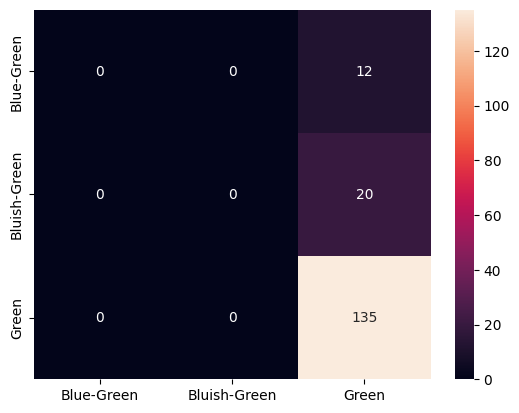

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_linear))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_linear))

# 5 Con ajuste de hiperparametros y cross validation

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [30, 50],

}


grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')


grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 300, 'max_samples': 50, 'min_samples_leaf': 10, 'n_estimators': 50, 'random_state': 42}

In [ ]:
rand_forest = RandomForestClassifier(class_weight='balanced',max_depth= 30, max_features='sqrt', max_leaf_nodes= 300, max_samples= 50, min_samples_leaf= 10, n_estimators= 50, random_state=42)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    rand_forest.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = rand_forest.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))



    fold += 1

El desbalance en las clases, donde la clase "Green" es significativamente más grande que las otras dos clases, afecta negativamente el rendimiento de los modelos de clasificación. Esto se evidencia en el hecho de que los modelos tienden a predecir predominantemente la clase mayoritaria.

Para el modelo SVC con kernel lineal, el rendimiento bajo y la predicción de todos los datos como pertenecientes a la clase "Green" da indicio de que el modelo lineal no es capaz de capturar la complejidad de las relaciones entre las características

La predicción de todos los datos como pertenecientes a la clase mayoritaria muestra que el modelo con kernel gaussiano también tiene dificultades para manejar la complejidad del problema.

La mejora ligera con RandomForest sugiere que los árboles de decisión son más capaces de capturar relaciones no lineales en los datos en comparación con los modelos lineales. 

El modelo lineal puede ser más sensible a outliers que afectan la relación lineal. Random Forest, al ser basado en árboles y mas robusto, puede ser menos propenso a la influencia de outliers.

El modelo SVC con kernel lineal asume una relación lineal entre las características y la variable objetivo. Por lo tanto, los coeficientes que asigna reflejan la contribución lineal de cada característica. Si las relaciones son complejas o no lineales, el modelo lineal puede no capturar completamente esas sutilezas.

Random Forest es un modelo más robusto que puede manejar relaciones no lineales y complejas entre las características y la variable objetivo. Al utilizar múltiples árboles de decisión y combinar sus resultados

El desbalance es uno de los mayores desafíos a considerar en el desempeño de los modelos.